<a href="https://colab.research.google.com/github/NTT123/ai-notebooks/blob/master/Manifold_Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Manifold Mixup: Better Representations by Interpolating Hidden States

https://arxiv.org/abs/1806.05236

Vikas Verma, Alex Lamb, Christopher Beckham, Amir Najafi, Ioannis Mitliagkas, Aaron Courville, David Lopez-Paz, Yoshua Bengio

In [0]:
## I need a better style sheet
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('classic')

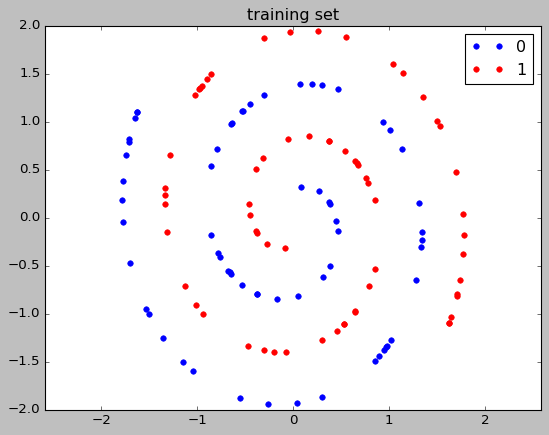

In [2]:
## Two-spirals dataset
## Source: https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html

import numpy as np

np.random.seed(42)

def twospirals(n_points, noise=.1):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 760 * (2*np.pi)/360
    d1x = -np.cos(n)*n + (np.random.rand(n_points,1)-0.5) * noise # fixed non-centered data
    d1y = np.sin(n)*n + (np.random.rand(n_points,1)-0.5) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

SX, Sy = twospirals(64, noise=0.0)
SX = SX / np.std(SX, axis=0, keepdims=True)  # unit variance

plt.title('training set')
plt.plot(SX[Sy==0,0], SX[Sy==0,1], '.', label='0', c="b", markersize=10)
plt.plot(SX[Sy==1,0], SX[Sy==1,1], '.', label='1', c="r", markersize=10)
plt.axis("equal")
_ = plt.legend()

In [0]:
import torch
from torch import nn
import numpy as np
from torch.distributions import Beta, Uniform

class MixupLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, lam):
        # x: [batch, dim], lam: [batch]
        x = x * lam + torch.flip(x, [0,]) * (1.0 - lam)
        return x

class MLP(nn.Module):
    def __init__(self, dim=256, bd=2):
        super().__init__()
        self.F = nn.ModuleList([ 
            nn.Linear(2, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, dim), 
            nn.LeakyReLU(0.1),  nn.Linear(dim, bd), MixupLayer(),  nn.Linear(bd, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, 1), 
        ])

        self.sampler = Uniform(0.0, 1.0) # or Beta(1, 1)

    def run_after_mid(self, x):
        t = False
        for f in self.F:
            if t: x = f(x)
            if isinstance(f, MixupLayer): t = True
        return x

    def forward(self, x, no_mixup=False):
        lam = torch.ones( x.size(0), 1) if no_mixup else self.sampler.sample( (x.size(0), 1) )
        lam = lam.to(x.device)

        for f in self.F:
            if isinstance(f, MixupLayer): mid, x  = x, f(x, lam) 
            else: x = f(x)
                
        return x, lam, mid

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MLP().to(device)

def init_weights(m):
    g = torch.nn.init.calculate_gain("leaky_relu", 0.1)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=g)
        m.bias.data.fill_(0.01)

net = net.apply(init_weights)
gs = 0
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=0.0)
criterion = torch.nn.BCEWithLogitsLoss()
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

writer = SummaryWriter("logs/1")

In [0]:
from torch.utils.data import DataLoader
dataset = list(zip(SX.astype("float32"), Sy.astype("float32")))
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [6]:
for epoch in range(1000):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device).view(-1, 1)

        pred, lam, mid = net(X, no_mixup=False)

        yf = torch.flip(y, dims=[0,])

        y1 = y * lam + yf * (1.0 - lam)
        loss = criterion(pred, y1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        gs = gs + 1
        writer.add_scalar("loss", loss.item(), gs)
        print("\r epoch: {}, loss: {:0.3f}".format(epoch, loss.item()), end="")

 epoch: 999, loss: 0.274

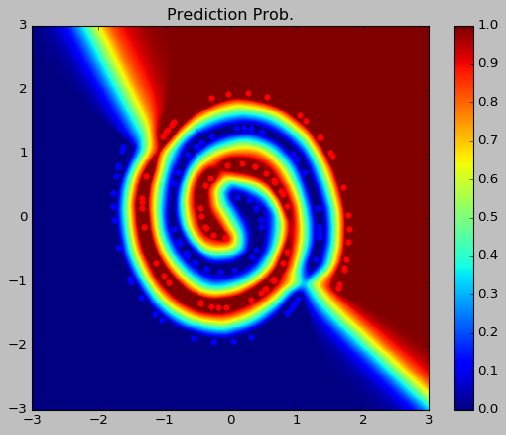

In [7]:
dtt = []
nn=401
vvv = np.linspace(-3,3, nn)
for i in range(nn):
    for j in range(nn):
        xx = vvv[i]
        yy = vvv[j]
        dtt.append([xx,yy])

dtt = np.asarray(dtt).astype("float32")
grd = torch.tensor(dtt).float().to(device)
yg, l, mid = net(grd, no_mixup=True)
yg = torch.sigmoid(yg)
heat = yg.data.cpu().numpy()
heat = heat.reshape((nn,nn))

Y, XX = np.meshgrid(vvv, vvv)

plt.title("Prediction Prob.")
plt.pcolormesh(XX, Y, heat )
plt.colorbar()
plt.plot(SX[Sy==0,0], SX[Sy==0,1], '.', label='0', c="b", markersize=10)
_ = plt.plot(SX[Sy==1,0], SX[Sy==1,1], '.', label='1', c="r", markersize=10)


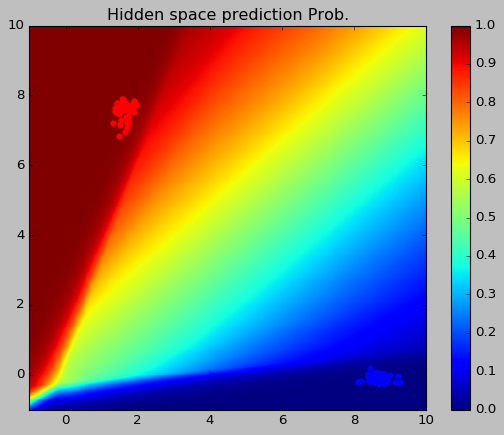

In [8]:
dtt = []

grd= torch.tensor(SX).float().to(device)
_, _, mid = net(grd, no_mixup=True)
minn = torch.min(mid).long().item() -1 
maxx = torch.max(mid).long().item() + 1

nn=401
vvv = np.linspace(minn,maxx, nn)
for i in range(nn):
    for j in range(nn):
        xx = vvv[i]
        yy = vvv[j]
        dtt.append([xx,yy])

dtt = np.asarray(dtt).astype("float32")
grd = torch.tensor(dtt).float().to(device)
yg = net.run_after_mid(grd).sigmoid()
heat = yg.data.cpu().numpy().reshape( (nn, nn) )

Y, XX = np.meshgrid(vvv, vvv)

plt.title("Hidden space prediction Prob.")
plt.pcolormesh(XX, Y, heat )
plt.colorbar()

grd= torch.tensor(SX).float().to(device)
yg, _, _ = net(grd, no_mixup=True)
yg = torch.sigmoid(yg)

mid = mid.data.cpu().numpy()
plt.plot(mid[Sy==0,0], mid[Sy==0,1], '.', label='0', c="b", markersize=10)
plt.plot(mid[Sy==1,0], mid[Sy==1,1], '.', label='1', c="r", markersize=10)

plt.xlim(minn, maxx)
_ = plt.ylim(minn, maxx)

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs